In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


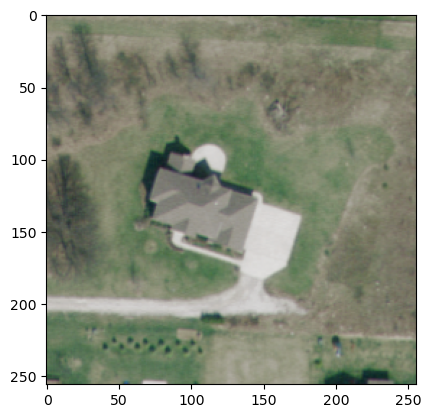

sparseresidential


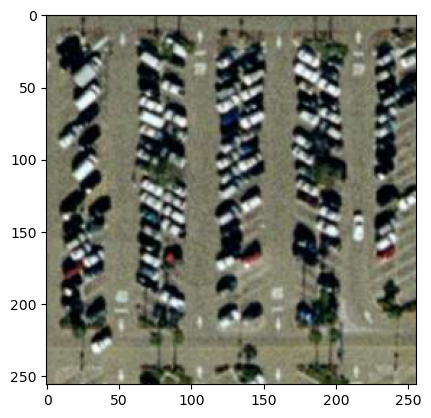

parkinglot


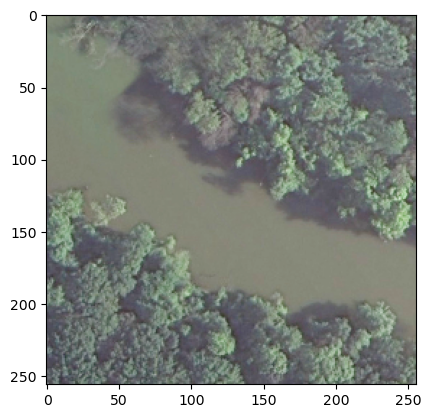

river


In [4]:
# Visualize Data
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

data_dir = '/home/megangordon/UCMerced_LandUse/Images/'

viz_transform = transforms.Compose([
    transforms.Resize((256, 256), transforms.InterpolationMode("bicubic")),
    transforms.ToTensor(),
    ])

viz_dataset = datasets.ImageFolder(root=data_dir, transform=viz_transform)
viz_dataloader = torch.utils.data.DataLoader(viz_dataset, batch_size=1, shuffle=True, num_workers=2)

classes = viz_dataloader.dataset.classes
print(classes)

for i, (image, label) in enumerate(viz_dataloader):
    plt.figure()
    plt.imshow(image[0].numpy().transpose(1, 2, 0))
    plt.show()
    print(f'{classes[label[0]]:5s}')
    if i == 2:
        break

In [5]:
# Calulate image dataset statistics for normalization
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html

# temp accumulators
temp_sum    = torch.tensor([0.0, 0.0, 0.0])
temp_sum_sq = torch.tensor([0.0, 0.0, 0.0])

# sum pixel values by looping through all images
for index, images in enumerate(viz_dataloader):
    image = images[0][0].numpy().transpose(1, 2, 0)
    temp_sum += image.sum(axis = (0, 1))
    temp_sum_sq += (image ** 2).sum(axis = (0, 1))
    if image.shape != (256,256,3):
        print('WRONG SIZE!',str(image.shape))

# count pixels total
count = len(viz_dataloader) * 256 * 256

# mean and std
dataset_mean = temp_sum / count
dataset_var  = (temp_sum_sq / count) - (dataset_mean ** 2)
dataset_std  = torch.sqrt(dataset_var)
print('mean: '  + str(dataset_mean))
print('std:  '  + str(dataset_std))

mean: tensor([0.4842, 0.4901, 0.4505])
std:  tensor([0.2180, 0.2020, 0.1958])


In [6]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256), transforms.InterpolationMode("bicubic")),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
    ])
batch_size = 16

all_data = datasets.ImageFolder(root=data_dir, transform=data_transform)
train_size = int(0.8 * len(all_data))
val_size = len(all_data) - train_size
train_dataset, val_dataset = random_split(all_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Visualize Normalized Data

for i, (image, label) in enumerate(trainloader):
    plt.figure()
    #image = image[0].numpy().transpose(1, 2, 0)
    #image = image * dataset_std.numpy()
    image = np.add(image, dataset_mean.numpy())
    plt.imshow(image)
    plt.show()
    print(f'{classes[label[0]]:5s}')
    if i == 2:
        break

In [7]:
# 2. Define a Convolutional Network
# https://github.com/GeneralLi95/PyTorch_UCMerced_LandUse/blob/master/models/lenet.py
# https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb

'''
if the input image is (256, 256)
256 - 0 = 256
256 / 2 = 128
128 - 0 = 128 
128 / 2 = 64 ...
therefore the input of fc1 should be 16 * 64 * 64 = 
'''

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding='same')
        self.pool1 = nn.MaxPool2d(2, 2, padding=0, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, 5, padding='same')
        self.pool2 = nn.MaxPool2d(2, 2, padding=0, ceil_mode=False)
        self.fc1 = nn.Linear(16*64*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 21)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16*64*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net, model_name = LeNet(), 'LeNet'
print(model_name + ' is ready!')

LeNet is ready!


In [10]:
# Setup for training
device = 'cpu' #sends to cpu. device = 'cuda', would send to gpu
net = net.to(device)
net = torch.nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,) # weight_decay=5e-4)

In [11]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    n_batches = len(train_loader)/batch_size # maybe should be trainset, not trainloader

    for i, (inputs, labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # calculate training loss statistic
        
        # print logs
        if i % n_batches == (n_batches-1):
            train_loss = running_loss / n_batches

            # calculate validation statistics
            with torch.no_grad():
                for (inputs, labels) in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = net(inputs) # calculate network outputs
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            print(f'[Epoch: {epoch + 1}] Train Loss: {train_loss:.5f}; Val Acc: {val_acc:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0
            
print('Finished Training')

[Epoch: 1] Train Loss: 45.62075; Val Acc: 23.57%
[Epoch: 2] Train Loss: 29.75899; Val Acc: 38.33%
[Epoch: 3] Train Loss: 11.87757; Val Acc: 47.14%
[Epoch: 4] Train Loss: 3.25831; Val Acc: 45.00%
[Epoch: 5] Train Loss: 1.16696; Val Acc: 39.52%
[Epoch: 6] Train Loss: 1.43764; Val Acc: 42.62%
[Epoch: 7] Train Loss: 0.65638; Val Acc: 40.71%
[Epoch: 8] Train Loss: 0.68608; Val Acc: 45.95%
[Epoch: 9] Train Loss: 0.03649; Val Acc: 49.29%
[Epoch: 10] Train Loss: 0.00983; Val Acc: 48.10%
[Epoch: 11] Train Loss: 0.00551; Val Acc: 47.14%
[Epoch: 12] Train Loss: 0.00415; Val Acc: 46.67%
[Epoch: 13] Train Loss: 0.00338; Val Acc: 46.90%
[Epoch: 14] Train Loss: 0.00274; Val Acc: 48.10%
[Epoch: 15] Train Loss: 0.00232; Val Acc: 47.86%
Finished Training


In [13]:
# Experiment with limited random data augmentation

rand_transform = transforms.Compose([
    transforms.Resize((256, 256), transforms.InterpolationMode("bicubic")),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
    ])

batch_size = 16

all_data = datasets.ImageFolder(root=data_dir, transform=rand_transform)
train_size = int(0.8 * len(all_data))
val_size = len(all_data) - train_size
train_dataset, val_dataset = random_split(all_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Setup for training
net, model_name = LeNet(), 'LeNet'
print('New ' + model_name + ' is ready!')
device = 'cpu'
net = net.to(device)
net = torch.nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    n_batches = len(train_loader)/batch_size # maybe should be trainset, not trainloader

    for i, (inputs, labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # calculate training loss statistic
        
        # print logs
        if i % n_batches == (n_batches-1):
            train_loss = running_loss / n_batches

            # calculate validation statistics
            with torch.no_grad():
                for (inputs, labels) in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = net(inputs) # calculate network outputs
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            print(f'[Epoch: {epoch + 1}] Train Loss: {train_loss:.5f}; Val Acc: {val_acc:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0
            
print('Finished Training')

New LeNet is ready!
[Epoch: 1] Train Loss: 45.34644; Val Acc: 19.52%
[Epoch: 2] Train Loss: 34.73945; Val Acc: 34.76%
[Epoch: 3] Train Loss: 26.87549; Val Acc: 43.57%
[Epoch: 4] Train Loss: 20.84423; Val Acc: 50.24%
[Epoch: 5] Train Loss: 16.38325; Val Acc: 54.76%
[Epoch: 6] Train Loss: 12.77427; Val Acc: 55.24%
[Epoch: 7] Train Loss: 9.18251; Val Acc: 55.00%
[Epoch: 8] Train Loss: 9.48531; Val Acc: 61.67%
[Epoch: 9] Train Loss: 6.10118; Val Acc: 60.00%
[Epoch: 10] Train Loss: 5.10093; Val Acc: 57.62%
[Epoch: 11] Train Loss: 4.09561; Val Acc: 55.95%
[Epoch: 12] Train Loss: 3.67229; Val Acc: 56.67%
[Epoch: 13] Train Loss: 2.51930; Val Acc: 58.10%
[Epoch: 14] Train Loss: 2.30615; Val Acc: 58.57%
[Epoch: 15] Train Loss: 1.69932; Val Acc: 61.90%
Finished Training


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Val Acc for class: {classname:5s}: {accuracy:.2f}%')

Val Acc for class: agricultural: 100.00%
Val Acc for class: airplane: 41.18%
Val Acc for class: baseballdiamond: 78.57%
Val Acc for class: beach: 95.00%
Val Acc for class: buildings: 44.44%
Val Acc for class: chaparral: 95.45%
Val Acc for class: denseresidential: 10.53%
Val Acc for class: forest: 100.00%
Val Acc for class: freeway: 54.55%
Val Acc for class: golfcourse: 77.27%
Val Acc for class: harbor: 100.00%
Val Acc for class: intersection: 72.00%
Val Acc for class: mediumresidential: 35.00%
Val Acc for class: mobilehomepark: 26.47%
Val Acc for class: overpass: 40.00%
Val Acc for class: parkinglot: 87.50%
Val Acc for class: river: 66.67%
Val Acc for class: runway: 65.00%
Val Acc for class: sparseresidential: 57.14%
Val Acc for class: storagetanks: 27.78%
Val Acc for class: tenniscourt: 54.17%
